In [1]:
import torch
import torch.nn as nn
import os 
import numpy as np
import torch.optim as optim
import time

# from torchvision import datasets, transforms

from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
import psutil
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
import papermill
import umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



/home/marcelino.maita/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading Lb vectors from:  ../../../../data/spotify_dataset_sin_duplicados_4.csv


In [3]:
class MLP(nn.Module):
    def __init__(self, capas):
        super(MLP, self).__init__()
        layers = []
        # Capas 
        for i in range(len(capas)-2):
            layers.append(nn.Linear(capas[i], capas[i+1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(capas[-2], capas[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
        


In [4]:
DATA_PATH ="../../../../data"
path_lb_embb = os.path.join(DATA_PATH, f"embbedings_khipu/tfidf_numeric_B.npy")
path_dataset = os.path.join(DATA_PATH, "spotify_dataset_sin_duplicados_4.csv")

## CONFIGURATIONS

TESTING = True
SCALED = True
_EMBEDDINGS = np.load(path_lb_embb , mmap_mode="r")

if TESTING:
    _NROWS = 9000
    _EMBEDDINGS = _EMBEDDINGS[:_NROWS]
    _EPHOCS = 30
else:
    _NROWS = None
    _EPHOCS = 30

if SCALED:
    scaler = MinMaxScaler(feature_range=(0, 1))
    _EMBEDDINGS = scaler.fit_transform(_EMBEDDINGS)

df = pd.read_csv(path_dataset, nrows = _NROWS)
df['Explicit_binary'] = df['Explicit'].map({'Yes': 1, 'No': 0})

X = _EMBEDDINGS

y = df['Explicit_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 
)

# Convertir data a tensores
# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # labels como enteros

X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.long)

# Crear datasets
trainDataset = TensorDataset(X_train_tensor, y_train_tensor)
testDataset  = TensorDataset(X_test_tensor,  y_test_tensor)

trainLoader = DataLoader(trainDataset, batch_size=64, shuffle= True)
testLoader  = DataLoader( testDataset, batch_size=64, shuffle=False)

In [5]:
net = MLP([X_train.shape[1],32, 64,32,1])
# Total de parámetros
total_params = sum(p.numel() for p in net.parameters())
print(f"Total parámetros: {total_params}")

# Parámetros entrenables
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Parámetros entrenables: {trainable_params}")

Total parámetros: 164833
Parámetros entrenables: 164833


In [6]:
# Pasar la red a la GPU
net = net.to(device)

# Loss
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.AdamW(net.parameters(), lr=0.001)

In [7]:
start_time = time.time() 

In [8]:
def train_deep_rn(net, trainLoader, testLoader, criterion, optimizer, device, n_epoch=20, target_f1=0.95, print_every=126):
    train_losses = []
    test_losses = []
    best_f1_score = 0.0
    best_pred = None
    best_ephoc = None
    best_labels = None
    AUC_according_best_f1 = 0.0

    for epoch in range(n_epoch):
        # Training
        net.train()
        total_train_loss = 0
        for embbedings, labels in trainLoader:
            embbedings, labels = embbedings.to(device), labels.to(device).float()
            outputs = net(embbedings).squeeze(1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(trainLoader)
        train_losses.append(avg_train_loss)

        # Evaluation
        net.eval()
        total_test_loss = 0
        all_preds, all_labels, all_probs = [], [], []
        with torch.no_grad():
            for embbedings, labels in testLoader:
                embbedings, labels = embbedings.to(device), labels.to(device).float()
                outputs = net(embbedings).squeeze(1)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
                probs = torch.sigmoid(outputs)
                preds = (probs >= 0.5).int()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        avg_test_loss = total_test_loss / len(testLoader)
        test_losses.append(avg_test_loss)

        # Metrics
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds)
        rec = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        auc = roc_auc_score(all_labels, all_probs) 
        if f1 > best_f1_score:
            best_f1_score = f1
            best_pred = all_preds
            best_ephoc = epoch
            best_labels = all_labels.copy()
            AUC_according_best_f1 = auc
            epocas= epoch
        if f1 >= target_f1:
            print(f"Target F1-score {target_f1} alcanzado en la época {epoch}. Deteniendo entrenamiento.")
            break
        if epoch % print_every == 0:
            print(f"Epoch [{epoch}/{n_epoch}] "
                  f"Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, "
                  f"F1: {f1:.4f}, AUC: {auc:.4f}")

    print("Mejores resultados en la época: ", best_ephoc)
    print("f1-score", best_f1_score)
    print("AUC según el mejor F1-score", AUC_according_best_f1)
    return train_losses,test_losses, best_f1_score, best_pred, best_ephoc, best_labels, AUC_according_best_f1



# train_losses,test_losses, best_f1_score, best_pred, best_ephoc, best_labels, AUC_according_best_f1 = train_deep_rn(net, trainLoader, testLoader, criterion, optimizer, device, n_epoch=_EPHOCS, target_f1=0.95, print_every=2)


In [9]:
def train_vs_eval_loss(train_losses, test_losses):
    epochs = len(train_losses)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Eval Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# train_vs_eval_loss(train_losses, test_losses)

In [10]:
def evaluar_modelo(y_true, y_pred, params=None, labels=('Not Explicit', 'Explicit'),
                save_dir="resultados"):
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    title = "Confusion Matrix"
    if params is not None:
        title += f" (Epoch = {params})"
    plt.title(title)

    # Guardar o mostrar
    # if save:
    os.makedirs(save_dir, exist_ok=True)
    filename = f"confusion_matrix_param_{params if params is not None else 'final'}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    print(f"Matriz de confusión guardada en: {filepath}")
    plt.close()
    # else:
    # plt.show()

    # Métricas
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy:   {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1-score:   {f1:.4f}")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }
# evaluar_modelo(best_labels, best_pred, 20, labels=('Not Explicit', 'Explicit'), save_dir="resulta3dos")
 

### f1-score VS cantidad de parámetros

In [11]:
nets = {
    # Pequeña y rápida
    "1": [X_train.shape[1], 32, 1],  
    
    # Mediana
    "2": [X_train.shape[1], 64, 32, 1],  
    
    # Más profunda
    # "3": [X_train.shape[1], 128, 64, 32, 1],  
    
    # # Red grande
    # "4": [X_train.shape[1], 256, 128, 64, 32, 1],  
    
    # # Variante con capas decrecientes más suaves
    # "5": [X_train.shape[1], 512, 256, 128, 64, 1],

    # "6": [X_train.shape[1], 1024, 512, 256, 128, 64, 32, 1],
}



Entrenando red 1 con capas [5018, 32, 1]

--- Iteración 1 de 4 para la red 1 ---


Epoch [0/30] Train Loss: 0.4904, Test Loss: 0.3047, F1: 0.7958, AUC: 0.9389


Epoch [10/30] Train Loss: 0.0218, Test Loss: 0.1969, F1: 0.8851, AUC: 0.9771


Epoch [20/30] Train Loss: 0.0042, Test Loss: 0.2607, F1: 0.8794, AUC: 0.9737


Mejores resultados en la época:  7
f1-score 0.8909853249475891
AUC según el mejor F1-score 0.9785272312761213


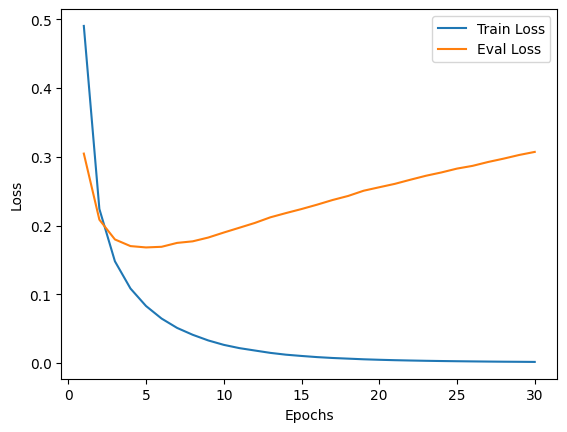

Confusion Matrix:
 [[1271   36]
 [  68  425]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_160641.png
Accuracy:   0.9422
Precision:  0.9219
Recall:     0.8621
F1-score:   0.8910

--- Iteración 2 de 4 para la red 1 ---


Epoch [0/30] Train Loss: 0.4630, Test Loss: 0.3005, F1: 0.7963, AUC: 0.9441


Epoch [10/30] Train Loss: 0.0224, Test Loss: 0.1992, F1: 0.8896, AUC: 0.9774


Epoch [20/30] Train Loss: 0.0043, Test Loss: 0.2720, F1: 0.8811, AUC: 0.9743


Mejores resultados en la época:  5
f1-score 0.8945147679324894
AUC según el mejor F1-score 0.9792566473862848


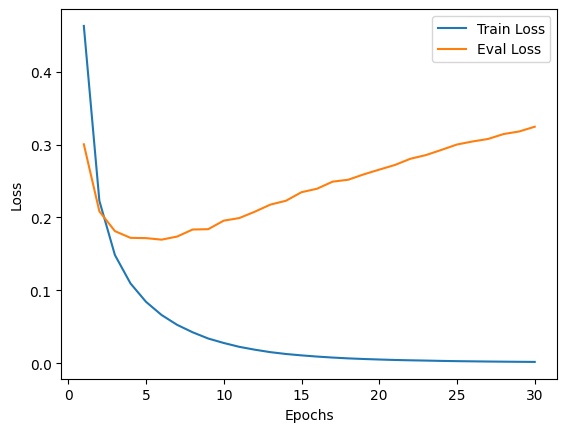

Confusion Matrix:
 [[1276   31]
 [  69  424]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_160641.png
Accuracy:   0.9444
Precision:  0.9319
Recall:     0.8600
F1-score:   0.8945

--- Iteración 3 de 4 para la red 1 ---


Epoch [0/30] Train Loss: 0.4695, Test Loss: 0.3049, F1: 0.7925, AUC: 0.9413


Epoch [10/30] Train Loss: 0.0211, Test Loss: 0.1969, F1: 0.8919, AUC: 0.9778


Epoch [20/30] Train Loss: 0.0040, Test Loss: 0.2662, F1: 0.8884, AUC: 0.9748


Mejores resultados en la época:  4
f1-score 0.8982161594963274
AUC según el mejor F1-score 0.9793218292514484


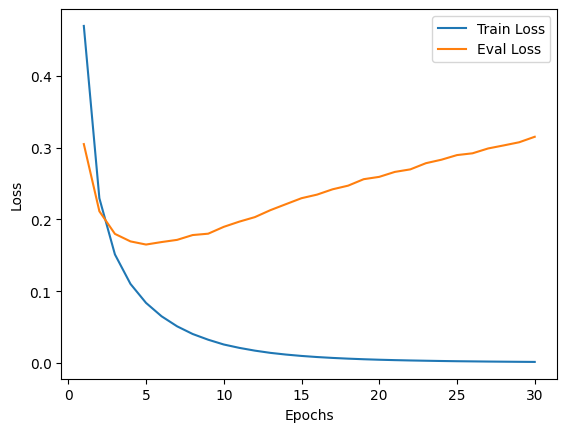

Confusion Matrix:
 [[1275   32]
 [  65  428]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_160641.png
Accuracy:   0.9461
Precision:  0.9304
Recall:     0.8682
F1-score:   0.8982

--- Iteración 4 de 4 para la red 1 ---


Epoch [0/30] Train Loss: 0.4771, Test Loss: 0.3085, F1: 0.7995, AUC: 0.9411


Epoch [10/30] Train Loss: 0.0220, Test Loss: 0.1978, F1: 0.8896, AUC: 0.9776


Epoch [20/30] Train Loss: 0.0042, Test Loss: 0.2665, F1: 0.8843, AUC: 0.9746


Mejores resultados en la época:  7
f1-score 0.895397489539749
AUC según el mejor F1-score 0.9789850562814366


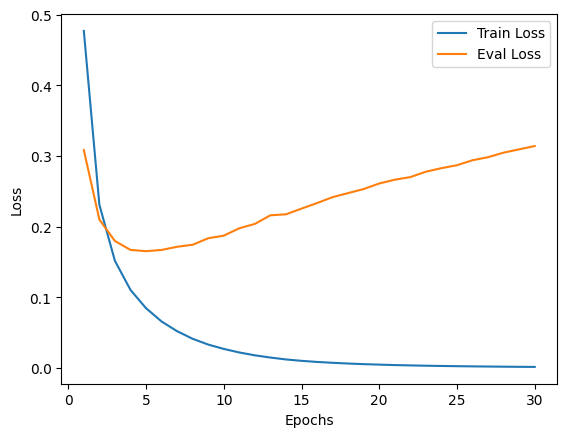

Confusion Matrix:
 [[1272   35]
 [  65  428]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_160641.png
Accuracy:   0.9444
Precision:  0.9244
Recall:     0.8682
F1-score:   0.8954
Tiempo total para red 1: 36.35 segundos

Entrenando red 2 con capas [5018, 64, 32, 1]

--- Iteración 1 de 4 para la red 2 ---


Epoch [0/30] Train Loss: 0.4278, Test Loss: 0.2140, F1: 0.8525, AUC: 0.9618


Epoch [10/30] Train Loss: 0.0007, Test Loss: 0.3748, F1: 0.8836, AUC: 0.9738


Epoch [20/30] Train Loss: 0.0001, Test Loss: 0.5080, F1: 0.8833, AUC: 0.9732


Mejores resultados en la época:  2
f1-score 0.8923719958202717
AUC según el mejor F1-score 0.9778257502510278


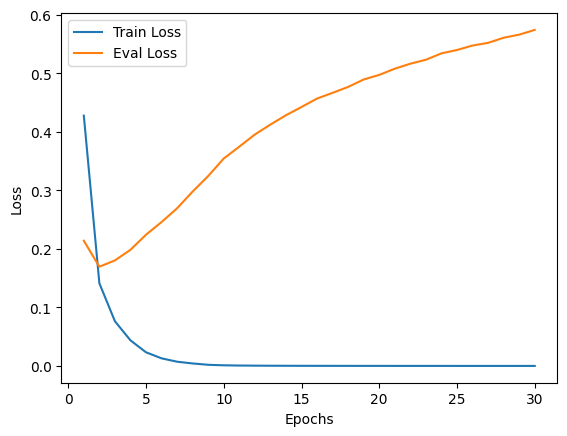

Confusion Matrix:
 [[1270   37]
 [  66  427]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_323329.png
Accuracy:   0.9428
Precision:  0.9203
Recall:     0.8661
F1-score:   0.8924

--- Iteración 2 de 4 para la red 2 ---


Epoch [0/30] Train Loss: 0.4354, Test Loss: 0.2163, F1: 0.8407, AUC: 0.9620


Epoch [10/30] Train Loss: 0.0008, Test Loss: 0.3393, F1: 0.8824, AUC: 0.9744


Epoch [20/30] Train Loss: 0.0001, Test Loss: 0.4096, F1: 0.8799, AUC: 0.9735


Mejores resultados en la época:  2
f1-score 0.8944099378881988
AUC según el mejor F1-score 0.9783642766132123


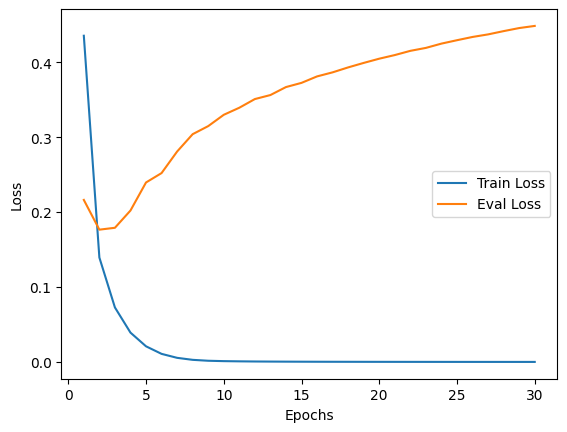

Confusion Matrix:
 [[1266   41]
 [  61  432]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_323329.png
Accuracy:   0.9433
Precision:  0.9133
Recall:     0.8763
F1-score:   0.8944

--- Iteración 3 de 4 para la red 2 ---


Epoch [0/30] Train Loss: 0.4120, Test Loss: 0.2063, F1: 0.8455, AUC: 0.9644


Epoch [10/30] Train Loss: 0.0011, Test Loss: 0.3474, F1: 0.8757, AUC: 0.9730


Epoch [20/30] Train Loss: 0.0000, Test Loss: 0.4794, F1: 0.8755, AUC: 0.9719


Mejores resultados en la época:  1
f1-score 0.8970588235294118
AUC según el mejor F1-score 0.9761962036219389


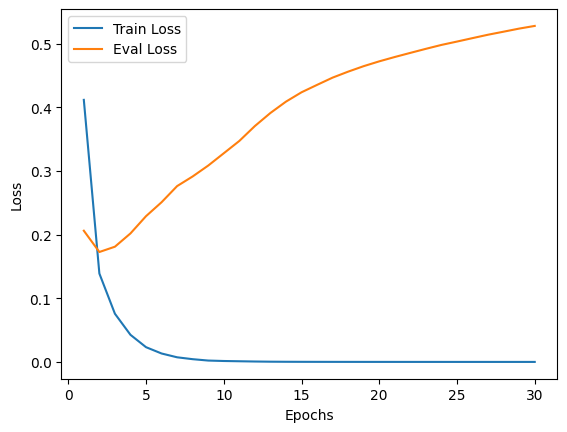

Confusion Matrix:
 [[1275   32]
 [  66  427]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_323329.png
Accuracy:   0.9456
Precision:  0.9303
Recall:     0.8661
F1-score:   0.8971

--- Iteración 4 de 4 para la red 2 ---


Epoch [0/30] Train Loss: 0.4275, Test Loss: 0.2046, F1: 0.8596, AUC: 0.9649


Epoch [10/30] Train Loss: 0.0009, Test Loss: 0.3423, F1: 0.8829, AUC: 0.9732


Epoch [20/30] Train Loss: 0.0001, Test Loss: 0.4139, F1: 0.8799, AUC: 0.9728


Mejores resultados en la época:  2
f1-score 0.90216271884655
AUC según el mejor F1-score 0.9785939650904554


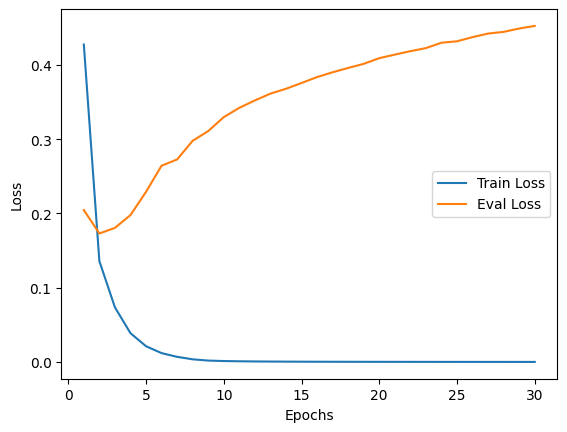

Confusion Matrix:
 [[1267   40]
 [  55  438]]


Matriz de confusión guardada en: resultados/confusion_matrix_param_323329.png
Accuracy:   0.9472
Precision:  0.9163
Recall:     0.8884
F1-score:   0.9022
Tiempo total para red 2: 38.46 segundos


In [12]:
veces = 4

n_params = []
f1_scores = []
for name, capas in nets.items():
    print(f"\nEntrenando red {name} con capas {capas}")
    net_ = MLP(capas)

    trainable_params = sum(p.numel() for p in net_.parameters() if p.requires_grad)
    n_params.append(trainable_params)

    
    start_time = time.time()  

    f1_score_result = 0.0
    for i in range(veces):
        print(f"\n--- Iteración {i+1} de {veces} para la red {name} ---")

        net = MLP(capas).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.AdamW(net.parameters(), lr=0.001)

        train_losses,test_losses, best_f1_score, best_pred, best_ephoc, best_labels, AUC_according_best_f1 = train_deep_rn(
            net, trainLoader, testLoader, criterion, optimizer, device, 
            n_epoch=_EPHOCS, target_f1=0.95, print_every=10
        )
        f1_score_result+=best_f1_score
        train_vs_eval_loss(train_losses, test_losses)

        evaluar_modelo(best_labels, best_pred, trainable_params, labels=('Not Explicit', 'Explicit'), save_dir=f"resultados")
    f1_scores.append(f1_score_result/veces)
    end_time = time.time() 
    elapsed_time = end_time - start_time
    print(f"Tiempo total para red {name}: {elapsed_time:.2f} segundos")


In [13]:
import numpy as np

np.save("resultados/n_params.npy", np.array(n_params))
np.save("resultados/f1_scores.npy", np.array(f1_scores))


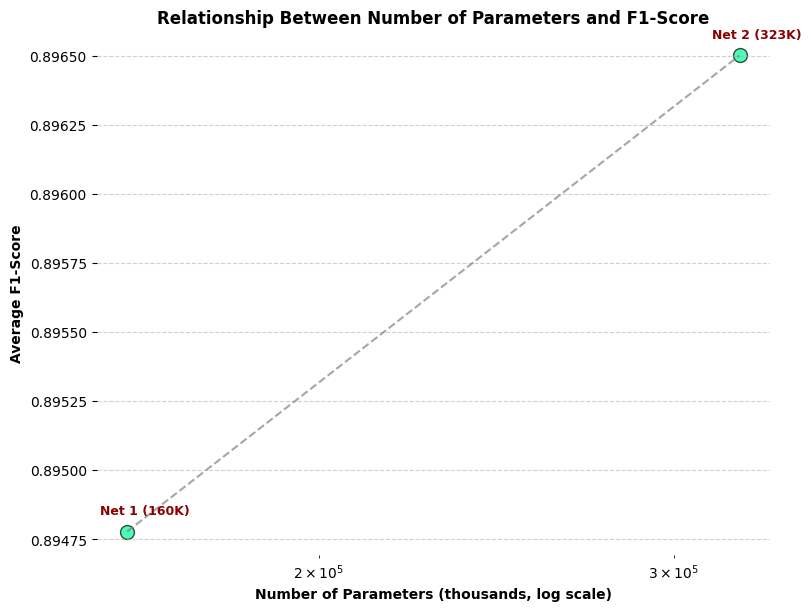

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)

# Tech green color
color_hex = "#00FA9A"  # MediumSpringGreen
ax.scatter(n_params, f1_scores, s=100, color=color_hex, alpha=0.7, edgecolors="k")
ax.plot(n_params, f1_scores, linestyle="--", color="gray", alpha=0.7)

# Labels for each point
for i, (x, y) in enumerate(zip(n_params, f1_scores), start=1):
    params_k = x // 1000
    ax.text(x + x*0.02, y + 0.00005, f"Net {i} ({params_k}K)",
            ha="center", va="bottom", fontsize=9, color="darkred", fontweight="bold")

# Remove plot borders
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

# Axis labels and title
ax.set_xscale("log")
ax.set_xlabel("Number of Parameters (thousands, log scale)", fontweight="bold")
ax.set_ylabel("Average F1-Score", fontweight="bold")
ax.set_title("Relationship Between Number of Parameters and F1-Score", fontweight="bold")
ax.grid(True, linestyle="--", alpha=0.6)
plt.savefig("resultados/params_vs_f1.png", dpi=300, bbox_inches="tight")
plt.show()
